<ipython-input-3-3a85838839e5>:139: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  ola = np.zeros((n * n), dtype=np.integer)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

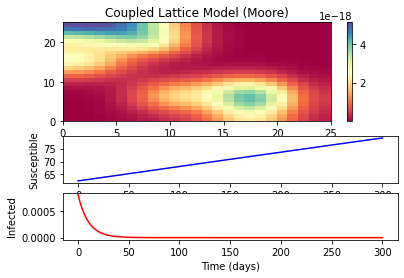

In [3]:
####################################################################
###    This is the PYTHON version of program 7.3 from page 256 of  #
### "Modeling Infectious Disease in humans and animals"            #
### by Keeling & Rohani.										   #
###																   #
### It is the SIR epidemic on an nxn lattice with coupling (rho)   #
### to 8 nearest neighbour. nI defines the number of lattice sites #
### (chosen randomly) that start with some infection.              #
####################################################################

###################################
### Written by Ilias Soumpasis    #
### ilias.soumpasis@ucd.ie (work) #
### ilias.soumpasis@gmail.com	  #
###################################

import scipy.integrate as spi
import numpy as np
import pylab as pl
import time
import cv2
import os
import matplotlib.cm as cm

### Select if you want to make a video (faster way) 
video = 1
### or just0in-time plotting
# video = 0
t = time.time()

n = 25
beta = .42
gamma = .14
mu = 0.0001
rho = 0.1
X0 = 0.1
nI = 8.
N0 = 1.0
nu = mu
timestep = 1.
# ND=MaxTime=2910 #changed
ND = MaxTime = 300  # changed
C = np.arange(0.0, 1.0, 0.001)
X = X0 * np.ones((n, n))
Y = np.zeros(n * n)
# ind = np.ceil(n * n * np.random.uniform(size=nI))
ind = np.ceil(n * n * np.random.uniform(size=int(nI))).astype(int)
for i in range(len(ind)):
    Y[ind[i]] = 0.001 * X0

INPUT1 = np.hstack((X0 * np.ones((n * n)), Y))

Y3 = Y
Y = np.reshape(Y, (n, n))
Y2 = Y

INPUT3 = np.hstack((X, Y))

INPUT2 = np.reshape(INPUT3, (2 * n * n, 1))

for i in range(len(INPUT1)):
    INPUT1[i] = INPUT2[i]

INPUT = INPUT1
ndem = np.zeros((n, n))
Size = n
N = N0
### Note the size loop
for i in range(Size):
    for j in range(Size):
        # ndem[i][j]=(1-4*rho)*N
        ndem[i][j] = (1 - 8 * rho) * N

        if i > 0: ndem[i][j] += rho * N
        if i < (Size - 1): ndem[i][j] += rho * N
        if j > 0: ndem[i][j] += rho * N
        if j < (Size - 1): ndem[i][j] += rho * N

        # Extra
        if i > 0 and j > 0: ndem[i][j] += rho * N
        if i < (Size - 1) and j < (Size - 1): ndem[i][j] += rho * N
        if i > 0 and j < (Size - 1): ndem[i][j] += rho * N
        if i < (Size - 1) and j > 0: ndem[i][j] += rho * N


def diff_eqs(INP, t):
    V = INP
    Y = np.zeros(2 * n * n)

    # internal dynamics
    for i in range(Size):
        for j in range(Size):
            ss = i + j * Size * 2
            ii = Size + i + j * Size * 2
            # Y[ss]=nu - beta*(1-4*rho)*V[ss]*V[ii]/ndem[i][j] - mu * V[ss]
            # Y[ii]=beta*(1-4*rho)*V[ss]*V[ii]/ndem[i][j] - (gamma + mu) * V[ii]
            Y[ss] = nu - beta * (1 - 8 * rho) * V[ss] * V[ii] / ndem[i][j] - mu * V[ss]
            Y[ii] = beta * (1 - 8 * rho) * V[ss] * V[ii] / ndem[i][j] - (gamma + mu) * V[ii]

            # Interactions with four neighbours - Moor neighborhood
            if i > 0:
                FoI = beta * V[ss] * rho * V[ii - 1] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI
            if i < (Size - 1):
                FoI = beta * V[ss] * rho * V[ii + 1] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI
            if j > 0:
                FoI = beta * V[ss] * rho * V[ii - Size * 2] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI
            if j < (Size - 1):
                FoI = beta * V[ss] * rho * V[ii + Size * 2] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI

            # Extra
            if i > 0 and j > 0:
                FoI = beta * V[ss] * rho * V[ii - 1 - Size * 2] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI
            if i < (Size - 1) and j < (Size - 1):
                FoI = beta * V[ss] * rho * V[ii + 1 + Size * 2] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI
            if i < (Size - 1) and j > 0:
                FoI = beta * V[ss] * rho * V[ii + 1 - Size * 2] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI
            if i > 0 and j < (Size - 1):
                FoI = beta * V[ss] * rho * V[ii - 1 + Size * 2] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI

    return Y


ola = np.zeros((n * n), dtype=np.integer)
for i in range(Size):
    for j in range(Size):
        ola[i * n + j] = i * Size * 2 + j

ola1 = ola + n
tcS = [(n * n * X0)]
tcI = [sum(Y3[range(n * n)])]
tc22 = np.zeros((n, n))
if video == 1:
    if os.path.exists('movie') == True:
        pass
    else:
        os.mkdir('movie')

    for k in range(ND):
        t_range = np.arange(2.0)
        RES = spi.odeint(diff_eqs, INPUT, t_range)
        INPUT = RES[-1]

        tcS.append(sum(RES[-1][ola]))
        tcI.append(sum(RES[-1][ola1]))

        if k % 1 == 0:
            pl.clf()
            tc22 = np.reshape(RES[-1][ola1], (n, n))
            pl.subplot(211)
            # pl.pcolor(tc22, cmap=pl.cm.spectral)
            pl.pcolor(tc22, cmap=cm.get_cmap("Spectral"))
            pl.title('Coupled Lattice Model (Moore)')
            pl.colorbar()

            pl.subplot(413)
            pl.plot(tcS, color='b')
            pl.ylabel('Susceptible')
            pl.subplot(414)
            pl.plot(tcI, color='r')
            pl.ylabel('Infected')
            pl.xlabel('Time (days)')
            pl.savefig("movie/frame_%04d.png" % k)
            # watch the progress
            print(k)

    # You will mencoder from mplayer for this to work
    # With windows you have to modify the path
    # With linux if you have mencoder istall usually it should work
    # Format is windows media player - plays on windows
    # You could try other formats also
    print('Please wait... Converting pictures to avi....')
    # Select different video speed
    #    os.system('mencoder "mf://movie/*.png" -mf fps=5:type=png -ovc lavc -lavcopts vcodec=wmv1 -of avi -o movie/movie_very_slow.avi')
    #    os.system('mencoder "mf://movie/*.png" -mf fps=10:type=png -ovc lavc -lavcopts vcodec=wmv1 -of avi -o movie/movie_slow.avi')
    # os.system(
    #     'mencoder "mf://movie/*.png" -mf fps=25:type=png -ovc lavc -lavcopts vcodec=wmv1 -of avi -o movie/movie_fast.avi')
    # print('Convertion completed. Hope it worked...')
    # ## Delete images to save work space
    # os.system('rm movie/*.png')
    #
    # print("Operation took %g seconds" % (time.time() - t))
    image_folder = 'movie'
    video_name = 'video.mp4' #.avi is 10 times bigger

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    frame_rate = 25
    video = cv2.VideoWriter(video_name, 0, frame_rate, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

    print('Conversion completed. Hope it worked...')
    # Delete images to save work space
    os.system('rm movie/*.png')

else:
    ## You could also try plotting at each step but it is slow
    pl.ion()
    for k in range(ND):
        t_range = np.arange(2.0)
        RES = spi.odeint(diff_eqs, INPUT, t_range)
        INPUT = RES[-1]

        tcS.append(sum(RES[-1][ola]))
        tcI.append(sum(RES[-1][ola1]))

        if k % 100 == 0:
            print(k)

        # Changing the k%50 parameter you change the frames you are watching
        #  With 1 you can see all the graphs
        """
        if k%10==0:
            pl.clf()
            tc22=np.reshape(RES[-1][ola1], (n,n))
            pl.subplot(211)
            pl.pcolor(tc22, cmap=pl.cm.spectral)
            pl.title('Coupled Lattice Model')
            pl.colorbar()
            pl.subplot(413)
            pl.plot(tcS, color='b')
            pl.ylabel('Susceptible')
            pl.subplot(414)
            pl.plot(tcI, color='r')
            pl.ylabel('Infected')
            pl.xlabel('Time (days)')
            ### watch the progress
            print k
            #pl.draw()
            """

    pl.clf()
    tc22 = np.reshape(RES[-1][ola1], (n, n))
    pl.subplot(211)
    # pl.pcolor(tc22, cmap=pl.cm.spectral)
    pl.pcolor(tc22, cmap=cm.get_cmap("Spectral"))
    pl.title('Coupled Lattice Model (Moore)')
    pl.colorbar()

    pl.subplot(413)
    pl.plot(tcS, color='b')
    pl.ylabel('Susceptible')

    pl.subplot(414)
    pl.plot(tcI, color='r')
    pl.ylabel('Infected')
    pl.xlabel('Time (days)')

    # watch the progress
#     print(k)
    pl.draw()

    pl.ioff()
    pl.show()

Please wait... Converting pictures to avis....
Conversion completed. Hope it worked...


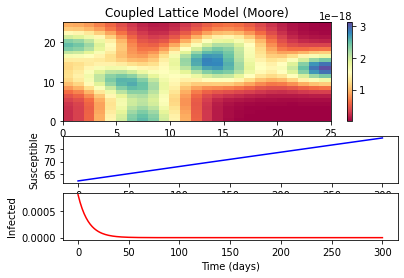

In [12]:
####################################################################
###    This is the PYTHON version of program 7.3 from page 256 of  #
### "Modeling Infectious Disease in humans and animals"            #
### by Keeling & Rohani.										   #
###																   #
### It is the SIR epidemic on an nxn lattice with coupling (rho)   #
### to 8 nearest neighbour. nI defines the number of lattice sites #
### (chosen randomly) that start with some infection.              #
####################################################################

###################################
### Written by Ilias Soumpasis    #
### ilias.soumpasis@ucd.ie (work) #
### ilias.soumpasis@gmail.com	  #
###################################

import scipy.integrate as spi
import numpy as np
import pylab as pl
import time
import cv2
import os
import matplotlib.cm as cm

### Select if you want to make a video (faster way) 
video = 1
### or just0in-time plotting
# video = 0
t = time.time()

n = 25
beta = .42
gamma = .14
mu = 0.0001
rho = 0.1
X0 = 0.1
nI = 8.
N0 = 1.0
nu = mu
timestep = 1.
# ND=MaxTime=2910 #changed
ND = MaxTime = 300  # changed
C = np.arange(0.0, 1.0, 0.001)
X = X0 * np.ones((n, n))
Y = np.zeros(n * n)
# ind = np.ceil(n * n * np.random.uniform(size=nI))
ind = np.ceil(n * n * np.random.uniform(size=int(nI))).astype(int)
for i in range(len(ind)):
    Y[ind[i]] = 0.001 * X0

INPUT1 = np.hstack((X0 * np.ones((n * n)), Y))

Y3 = Y
Y = np.reshape(Y, (n, n))
Y2 = Y

INPUT3 = np.hstack((X, Y))

INPUT2 = np.reshape(INPUT3, (2 * n * n, 1))

for i in range(len(INPUT1)):
    INPUT1[i] = INPUT2[i]

INPUT = INPUT1
ndem = np.zeros((n, n))
Size = n
N = N0
### Note the size loop
for i in range(Size):
    for j in range(Size):
        # ndem[i][j]=(1-4*rho)*N
        ndem[i][j] = (1 - 8 * rho) * N

        if i > 0: ndem[i][j] += rho * N
        if i < (Size - 1): ndem[i][j] += rho * N
        if j > 0: ndem[i][j] += rho * N
        if j < (Size - 1): ndem[i][j] += rho * N

        # Extra
        if i > 0 and j > 0: ndem[i][j] += rho * N
        if i < (Size - 1) and j < (Size - 1): ndem[i][j] += rho * N
        if i > 0 and j < (Size - 1): ndem[i][j] += rho * N
        if i < (Size - 1) and j > 0: ndem[i][j] += rho * N


def diff_eqs(INP, t):
    V = INP
    Y = np.zeros(2 * n * n)

    # internal dynamics
    for i in range(Size):
        for j in range(Size):
            ss = i + j * Size * 2
            ii = Size + i + j * Size * 2
            # Y[ss]=nu - beta*(1-4*rho)*V[ss]*V[ii]/ndem[i][j] - mu * V[ss]
            # Y[ii]=beta*(1-4*rho)*V[ss]*V[ii]/ndem[i][j] - (gamma + mu) * V[ii]
            Y[ss] = nu - beta * (1 - 8 * rho) * V[ss] * V[ii] / ndem[i][j] - mu * V[ss]
            Y[ii] = beta * (1 - 8 * rho) * V[ss] * V[ii] / ndem[i][j] - (gamma + mu) * V[ii]

            # Interactions with four neighbours - Moor neighborhood
            if i > 0:
                FoI = beta * V[ss] * rho * V[ii - 1] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI
            if i < (Size - 1):
                FoI = beta * V[ss] * rho * V[ii + 1] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI
            if j > 0:
                FoI = beta * V[ss] * rho * V[ii - Size * 2] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI
            if j < (Size - 1):
                FoI = beta * V[ss] * rho * V[ii + Size * 2] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI

            # Extra
            if i > 0 and j > 0:
                FoI = beta * V[ss] * rho * V[ii - 1 - Size * 2] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI
            if i < (Size - 1) and j < (Size - 1):
                FoI = beta * V[ss] * rho * V[ii + 1 + Size * 2] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI
            if i < (Size - 1) and j > 0:
                FoI = beta * V[ss] * rho * V[ii + 1 - Size * 2] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI
            if i > 0 and j < (Size - 1):
                FoI = beta * V[ss] * rho * V[ii - 1 + Size * 2] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI

    return Y


ola = np.zeros((n*n), dtype=int)
for i in range(Size):
    for j in range(Size):
        ola[i * n + j] = i * Size * 2 + j

ola1 = ola + n
tcS = [(n * n * X0)]
tcI = [sum(Y3[range(n * n)])]
tc22 = np.zeros((n, n))
if video == 1:
    if os.path.exists('movie') == True:
        pass
    else:
        os.mkdir('movie')

    for k in range(ND):
        t_range = np.arange(2.0)
        RES = spi.odeint(diff_eqs, INPUT, t_range)
        INPUT = RES[-1]

        tcS.append(sum(RES[-1][ola]))
        tcI.append(sum(RES[-1][ola1]))

        if k % 1 == 0:
            pl.clf()
            tc22 = np.reshape(RES[-1][ola1], (n, n))
            pl.subplot(211)
            # pl.pcolor(tc22, cmap=pl.cm.spectral)
            pl.pcolor(tc22, cmap=cm.get_cmap("Spectral"))
            pl.title('Coupled Lattice Model (Moore)')
            pl.colorbar()

            pl.subplot(413)
            pl.plot(tcS, color='b')
            pl.ylabel('Susceptible')
            pl.subplot(414)
            pl.plot(tcI, color='r')
            pl.ylabel('Infected')
            pl.xlabel('Time (days)')
            pl.savefig("movie/frame_%04d.png" % k)
            # watch the progress
#             print(k)

    # You will mencoder from mplayer for this to work
    # With windows you have to modify the path
    # With linux if you have mencoder istall usually it should work
    # Format is windows media player - plays on windows
    # You could try other formats also
    print('Please wait... Converting pictures to avis....')
    # Select different video speed
    #    os.system('mencoder "mf://movie/*.png" -mf fps=5:type=png -ovc lavc -lavcopts vcodec=wmv1 -of avi -o movie/movie_very_slow.avi')
    #    os.system('mencoder "mf://movie/*.png" -mf fps=10:type=png -ovc lavc -lavcopts vcodec=wmv1 -of avi -o movie/movie_slow.avi')
    # os.system(
    #     'mencoder "mf://movie/*.png" -mf fps=25:type=png -ovc lavc -lavcopts vcodec=wmv1 -of avi -o movie/movie_fast.avi')
    # print('Convertion completed. Hope it worked...')
    # ## Delete images to save work space
    # os.system('rm movie/*.png')
    #
    # print("Operation took %g seconds" % (time.time() - t))
    image_folder = 'movie'
    video_name = 'video.mp4'

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    frame_rate = 25
    video = cv2.VideoWriter(video_name, 0, frame_rate, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

    print('Conversion completed. Hope it worked...')
    # Delete images to save work space
    os.system('rm movie/*.png')

else:
    ## You could also try plotting at each step but it is slow
    pl.ion()
    for k in range(ND):
        t_range = np.arange(2.0)
        RES = spi.odeint(diff_eqs, INPUT, t_range)
        INPUT = RES[-1]

        tcS.append(sum(RES[-1][ola]))
        tcI.append(sum(RES[-1][ola1]))

        if k % 100 == 0:
            print(k)

        # Changing the k%50 parameter you change the frames you are watching
        #  With 1 you can see all the graphs
        """
        if k%10==0:
            pl.clf()
            tc22=np.reshape(RES[-1][ola1], (n,n))
            pl.subplot(211)
            pl.pcolor(tc22, cmap=pl.cm.spectral)
            pl.title('Coupled Lattice Model')
            pl.colorbar()
            pl.subplot(413)
            pl.plot(tcS, color='b')
            pl.ylabel('Susceptible')
            pl.subplot(414)
            pl.plot(tcI, color='r')
            pl.ylabel('Infected')
            pl.xlabel('Time (days)')
            ### watch the progress
            print k
            #pl.draw()
            """

    pl.clf()
    tc22 = np.reshape(RES[-1][ola1], (n, n))
    pl.subplot(211)
    # pl.pcolor(tc22, cmap=pl.cm.spectral)
    pl.pcolor(tc22, cmap=cm.get_cmap("Spectral"))
    pl.title('Coupled Lattice Model (Moore)')
    pl.colorbar()

    pl.subplot(413)
    pl.plot(tcS, color='b')
    pl.ylabel('Susceptible')

    pl.subplot(414)
    pl.plot(tcI, color='r')
    pl.ylabel('Infected')
    pl.xlabel('Time (days)')

    # watch the progress
    print(k)
    pl.draw()

    pl.ioff()
    pl.show()